I am assuming we have access two jsonls
- Student Outptuts
    - `index`: Unique identifier for each question.
    - `output`: The model's response to the question.

- Hidden Test Set with the following fields:
    - `index`: Unique identifier for each question.
    - `task`: The name of the task (e.g., "mmlu_med").
    - `prompt`: The question prompt presented to the model.
    - `gold_answer`: The correct answer to the question.
    - (Not needed)`meta`: Additional metadata about the question, including unique id in the dataset and other fields.

For this grading logic, we assume we can get the task and other info by essentially grouping by `index` from the hidden test set and joining with the student outputs on `index`.
""

In [ ]:
import json
import os
from tqdm import tqdm
from typing import List, Dict, Any
from grader import (
    InfoBenchEvaluator,
    GraphEvaluator,
    MMLUEvaluator,
    ResponseParser,
    evaluate_single
)
import nest_asyncio
nest_asyncio.apply()

## create test dataset

In [15]:
# import re
# import math_verify
# test = math_verify.parse("\\boxed{B}")
# # response = "The answer is (C)."
# response = "The answer is B."
# gt = "B"

# def extract_answer(response: str) -> str:
#     answer_match = re.search(r'The answer is\s*\(?([A-Z])\)?', response, re.IGNORECASE)
#     if answer_match:
#         return [answer_match.group(1).upper()]
#     return []

# answer = extract_answer(response)
# print(answer)
# math_verify.verify(gt, test), math_verify.verify(gt, answer)


In [3]:
student_outputs_data = [
    # Index 1: Graph (1 path) - CORRECT (function call format)
    {
        "index": 1,
        "output": "To find the shortest path from node 0 to node 9, I'll use Dijkstra's algorithm.\n\nLooking at the edges from node 0: 0->8 has weight 3, which is the smallest.\nFrom node 8: 8->9 has weight 22.\nTotal: 3 + 22 = 25\n\nsubmit_paths(paths=[[0, 8, 9]], weights=[25])"
    },

    # Index 2: Graph (3 paths) - PARTIALLY CORRECT (2 of 3, gold-like format)
    {
        "index": 2,
        "output": "Finding top 3 shortest paths from 0 to 15:\n\n1. 0 -> 7 -> 8 -> 15: 77 + 45 + 108 = 230\n2. 0 -> 4 -> 8 -> 15: 125 + 28 + 108 = 261\n\n{\"paths\": [{\"path\": [0, 7, 8, 15], \"weight\": 230}, {\"path\": [0, 4, 8, 15], \"weight\": 261}]}"
    },

    # Index 3: InfoBench (PyTorch NN) - GOOD (has comments, correct structure)
    {
        "index": 3,
        "output": """```python
import torch
import torch.nn as nn

# Define a two-hidden layer feedforward neural network
class TwoHiddenLayerNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(TwoHiddenLayerNN, self).__init__()

        # First hidden layer with 64 neurons
        self.fc1 = nn.Linear(input_size, 64)

        # Second hidden layer with 64 neurons
        self.fc2 = nn.Linear(64, 64)

        # Output layer
        self.fc3 = nn.Linear(64, output_size)

        # ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass through first hidden layer with ReLU
        x = self.relu(self.fc1(x))

        # Pass through second hidden layer with ReLU
        x = self.relu(self.fc2(x))

        # Output layer (no activation for raw logits)
        x = self.fc3(x)
        return x

# Example usage
model = TwoHiddenLayerNN(input_size=10, output_size=2)
```"""
    },

    # Index 4: InfoBench (Email) - PARTIAL (is email, about salary, but too short/informal)
    {
        "index": 4,
        "output": "Subject: Salary\n\nHi,\n\nI want more money.\n\nThanks"
    },

    # Index 5: MMLU - CORRECT
    {
        "index": 5,
        "output": "Let me analyze each option:\n\n- Glucose: ~4 kcal/gram\n- Palmitic acid (fat): ~9 kcal/gram\n- Leucine (amino acid): ~4 kcal/gram\n- Alcohol: ~7 kcal/gram\n\nFats release the most energy when oxidized. Palmitic acid is a fatty acid.\n\nThe answer is \\boxed{B}"
    },

    # Index 6: MMLU - WRONG (chose A instead of C)
    {
        "index": 6,
        "output": "The patient has elevated lymphocytes, which suggests leukemia. Since they're B-cell origin, it's lymphocytic. The answer is \\boxed{A}"
    }
]
# Save to file
with open("student_outputs.jsonl", "w") as f:
    for item in student_outputs_data:
        f.write(json.dumps(item) + "\n")
print("Created student_outputs.jsonl")

Created student_outputs.jsonl


In [16]:
def load_hidden_test(path: str) -> List[Dict[str, Any]]:
    """Load hidden test JSONL file."""
    data = []
    with open(path, 'r') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data


def load_student_outputs(path: str) -> Dict[int, str]:
    """Load student outputs JSONL, return dict mapping index -> output."""
    outputs = {}
    with open(path, 'r') as f:
        for line in f:
            if line.strip():
                item = json.loads(line)
                outputs[item["index"]] = item.get("output", "")
    return outputs

In [17]:
def save_jsonl(data: list, path: str):
    """Save list of dicts to JSONL."""
    os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
    with open(path, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + "\n")


def save_json(data: dict, path: str):
    """Save dict to JSON."""
    os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
    with open(path, 'w') as f:
        json.dump(data, f, indent=2)

In [18]:
# NOTe: Remove later helper for printing metrics

def print_metrics(metrics: dict):
    """Print metrics summary."""
    print("\n" + "=" * 50)
    print(f"RESULTS: {metrics['student_id']}")
    print("=" * 50)
    for task, m in metrics["task_metrics"].items():
        print(f"{task:12s}: {m['accuracy']:.4f} ({m['count']} examples)")
    print("-" * 50)
    print(f"{'OVERALL':12s}: {metrics['overall_accuracy']:.4f}")
    print("=" * 50)


## Run Evaluation

In [19]:
# ============================================================================
# METRICS
# ============================================================================
def calculate_metrics(results: list, student_id: str) -> dict:
    """Calculate task-wise and overall metrics."""
    task_scores = {"mmlu_med": [], "graph": [], "infobench": []}

    for r in results:
        task = r["task"]
        if task in task_scores:
            task_scores[task].append(r["score"])

    metrics = {
        "student_id": student_id,
        "total_examples": len(results),
        "task_metrics": {},
        "overall_accuracy": 0.0
    }

    all_scores = []
    for task, scores in task_scores.items():
        if scores:
            metrics["task_metrics"][task] = {
                "count": len(scores),
                "accuracy": sum(scores) / len(scores),
                "total_score": sum(scores)
            }
            all_scores.extend(scores)

    if all_scores:
        metrics["overall_accuracy"] = sum(all_scores) / len(all_scores)

    return metrics

In [20]:
def run_eval(
    hidden_test: list,
    student_outputs: dict,
    infobench_evaluator: InfoBenchEvaluator
) -> list:
    """Run evaluation on all test items."""
    results = []

    for idx, test_item in enumerate(tqdm(hidden_test, desc="Evaluating")):
        index = test_item["index"]
        student_response = student_outputs.get(index, "")
        result = evaluate_single(idx, test_item, student_response, infobench_evaluator)
        results.append(result)

    return results


# RUN EVALUATION

In [ ]:
openai_key = ''

In [67]:

# === Configuration ===
HIDDEN_TEST_PATH = "combined_dataset.jsonl"
STUDENT_OUTPUT_PATH = "student_outputs_accuracy_q32b.jsonl"
OUTPUT_DIR = "./eval_results"
STUDENT_ID = "tianyuca_accuracy_q32b"
EVAL_MODEL = "gpt-5-nano-2025-08-07"

if not openai_key:
    raise ValueError("OPENAI_API_KEY environment variable not set.")
# === Load data ===
print("Loading data...")
hidden_test = load_hidden_test(HIDDEN_TEST_PATH)
student_outputs = load_student_outputs(STUDENT_OUTPUT_PATH)

print(f"Hidden test size: {len(hidden_test)}")
print(f"Student outputs: {len(student_outputs)}")

Loading data...
Hidden test size: 300
Student outputs: 300


In [68]:
# # === Initialize InfoBench Evaluator ===
print("\nInitializing InfoBench evaluator...")
infobench_evaluator = InfoBenchEvaluator(openai_key, EVAL_MODEL)

# print("Verifying OpenAI connection...")
# if not infobench_evaluator.verify_connection():
#     raise RuntimeError("OpenAI connection failed - cannot proceed")
# print("OpenAI connection verified ✓")



Initializing InfoBench evaluator...


In [69]:
# === Run Evaluation ===
print(f"\nEvaluating: {STUDENT_ID}")
print("-" * 50)
results = run_eval(hidden_test, student_outputs, infobench_evaluator)

# === Calculate Metrics ===\
metrics = calculate_metrics(results, STUDENT_ID)


Evaluating: tianyuca_accuracy_q32b
--------------------------------------------------


Evaluating:   0%|          | 0/300 [00:00<?, ?it/s]

Q1: Is the generated text a list of words? => YES
Q2: Does the generated list contain exactly 10 words? => YES


Evaluating:   1%|▏         | 4/300 [00:07<09:39,  1.96s/it]

Q3: Do all the words in the generated text follow the consonant-vowel-consonant pattern? => YES
Q1: Does the generated text contain some words? => YES


Evaluating:   2%|▏         | 6/300 [00:22<20:47,  4.24s/it]

Q2: Are the words in the generated text rhyme with the word in the given input? => NO
Q1: Is the generated text a movie name? => NO


Evaluating:   2%|▏         | 7/300 [00:37<32:02,  6.56s/it]

Q2: Is the generated movie name relevant to the given emojis? => NO
Q1: Does the generated text present a vegetarian pasta recipe? => YES
Q2: Does the generated recipe incorporate at least five ingredients? => YES
Q3: Does the generated recipe follow a straightforward, five-step cooking procedure? => YES
Q4: Does the generated text include a clear list of ingredients along with their respective measurements? => YES
Q5: Are the preparation steps in the recipe presented with succinct descriptions? => YES


Evaluating:   4%|▍         | 12/300 [01:01<26:23,  5.50s/it]

Q6: Is the generated recipe exclusively making use of the specified cookware - a frying pan, saucepan, and stockpot - while avoiding the mention of any other cookware not included in the list? => YES
Q1: Does the generated text include a personalized career development plan? => YES
Q2: Is the generated career development plan specifically designed for a 2nd-year college student majoring in languages, who aspires to transition into AI engineering with a specialization in natural language processing? => YES
Q3: Does the generated career development plan account for the student's current major in languages and emphasize how this background can be beneficial in their pursuit of a career in AI? => YES
Q4: Does the generated career development plan provide a guide for the student to follow in their transition from a language major to an AI engineer? => YES
Q5: Is the guide in the generated career development plan presented in a step-by-step manner? => YES
Q6: Does the career development plan

Evaluating:   5%|▌         | 16/300 [01:20<24:40,  5.21s/it]

Q7: Does the career development plan include internships to pursue and networking opportunities? => NO
Q1: Does the generated text include two distinct basketball training routines? => NO
Q2: Are the generated training routines specifically tailored for two high school students with different goals? => NO
Q3: Is one routine in the generated text designed for a student who enjoys basketball as a hobby? => YES
Q4: Is there a routine in the generated text for a student who aspires to play basketball professionally? => NO


Evaluating:   7%|▋         | 20/300 [01:52<29:12,  6.26s/it]

Q5: Do the generated routines ensure that each has an appropriate training intensity and objectives, tailored to the specific needs and aspirations of each student? => NO
Q1: Does the generated text include a riddle? => YES
Q2: Does the generated text include a solution and an explanation? => YES
Q3: Is the riddle in the generated text four lines long? => YES
Q4: Is the riddle in the generated text suitable for all ages? => YES
Q5: Is the generated solution related to a popular fairy tale character or story? => YES


Evaluating:   7%|▋         | 21/300 [02:20<40:46,  8.77s/it]

Q6: Do the riddle, provided solution and explanation in the generated text make sense? => NO
Q1: Does the generated text provide a weather forecast? => YES
Q2: Does the generated forecast cover a period of seven days? => NO
Q3: Is the forecast generated for a specific, identified city, whether real or fictitious? => YES
Q4: Does the generated forecast include both the expected high and low temperatures for each day? => NO
Q5: Does the generated forecast provide information about the likelihood of precipitation and expected weather conditions (e.g. sunny, rainy, cloudy) for each day? => NO
Q6: Does the generated forecast specify the approximate times of sunrise and sunset for each day? => NO


Evaluating:   9%|▉         | 27/300 [02:47<30:05,  6.61s/it]

Q7: Does the generated forecast include a brief comment on the expected air quality for each day? => NO
Q1: Is the generated text a list of questions? => YES
Q2: Are the questions in the generated text suitable to start a conversation? => YES


Evaluating:   9%|▉         | 28/300 [02:54<30:34,  6.75s/it]

Q3: Are the questions in the generated text related to the weather? => YES
Q1: Is the generated text a response to the chat in the given input? => NO


Evaluating:  11%|█         | 32/300 [03:04<22:46,  5.10s/it]

Q2: Is the generated reponse funny? => YES
Q1: Is the generated text a bash command? => NO


Evaluating:  12%|█▏        | 35/300 [03:22<23:38,  5.35s/it]

Q2: Does the generated bash command accurately represent the description in the given input? => YES
Q1: Is the generated text lecture notes? => YES
Q2: Are the generated lecture notes focused on Quantum Mechanics? => YES
Q3: Do the generated lecture notes primarily concentrate on the Schrödinger Equation and the Dirac Equation? => YES
Q4: Does each topic in the generated lecture notes contain several bullet points accompanied by brief explanations? => NO
Q5: Does each topic in the generated lecture notes include at least one relevant equation? => YES
Q6: Are the equations in the generated lecture notes formatted using LaTeX code to ensure readability? => YES


Evaluating:  13%|█▎        | 38/300 [03:48<27:42,  6.35s/it]

Q7: Are the generated lecture notes concise and well-structured? => YES
Q1: Is the generated text a brief interview? => NO
Q2: Is the generated interview conducted between a journalist and an astronaut who recently returned from a Mars mission? => YES
Q3: Does the generated interview discuss the challenges and discoveries encountered during the Mars mission? => YES
Q4: Does the generated interview include 5 question and answer pairs? => YES
Q5: Does the generated interview conclude with a short poem by the astronaut? => YES


Evaluating:  14%|█▍        | 42/300 [04:09<25:35,  5.95s/it]

Q6: Does the poem in the generated interview capture the beauty of space? => YES
Q1: Is the generated text a description of the book in the given input? => YES


Evaluating:  15%|█▌        | 45/300 [04:16<20:47,  4.89s/it]

Q2: Is the generated description brief? => YES
Q1: Does the generated text provide meeting information? => YES


Evaluating:  17%|█▋        | 50/300 [04:22<14:26,  3.47s/it]

Q2: Is the meeting information in the generated text correctly extracted from the conversation in the given input? => NO
Q1: Does the generated text identify whether the two questions in the given input are duplicates? => YES


Evaluating:  17%|█▋        | 51/300 [04:28<15:18,  3.69s/it]

Q2: Is the judgment made by the generated text regarding the duplication of the given two questions reasonable? => YES
Q1: Is the generated text a fourteen-line poem? => YES
Q2: Does the generated poem adhere to the style of William Shakespeare? => YES
Q3: Does the generated poem express a love for life? => YES


Evaluating:  18%|█▊        | 53/300 [05:06<29:24,  7.14s/it]

Q4: Does the rhyme scheme of the generated poem follow the pattern ababcdcdefefgg, with the first twelve lines alternating rhymes and the final two lines sharing a rhyme? => NO
Q1: Is the generated text structured as a chemical safety data sheet for sodium chloride (table salt)? => YES
Q2: Does the generated text include a section on physical and chemical properties that describes the physical properties of sodium chloride? => YES
Q3: In the description of the physical properties of sodium chloride, are exactly three adjectives used? => NO
Q4: Does the generated text include a section on the potential hazards of sodium chloride? => YES
Q5: Does the generated text include a section on handling and storage procedures for sodium chloride? => YES
Q6: Does the generated text include a section on first-aid measures? => YES


Evaluating:  19%|█▉        | 58/300 [05:56<33:56,  8.42s/it]

Q7: Is all the information provided in the generated text factual and accurate according to known chemical safety data on sodium chloride? => NO
Q1: Is the generated text a list of links? => YES
Q2: Are the generated links relevant to a coding problem? => YES


Evaluating:  20%|█▉        | 59/300 [06:05<34:12,  8.52s/it]

Q3: Are the generated links helpful for the search term in the given input? => YES
Q1: Does the generated text determine whether the movie in the given input is suitable for children to watch? => YES


Evaluating:  21%|██▏       | 64/300 [06:17<22:42,  5.77s/it]

Q2: If the determination is "No", does the generated text mention what makes the given movie inappropriate for children? => YES
Q1: Does the generated text discuss the origins and history of the word in the given input? => YES


Evaluating:  22%|██▏       | 66/300 [06:46<29:31,  7.57s/it]

Q2: Is the generated discussion of word origins and history correct for the word in the given input? => NO
Q1: Does the generated text include two sentences? => YES
Q2: Are the two generated sentences palindromic? => YES
Q3: Is one of the generated sentences in English and the other in Chinese? => YES
Q4: Is each sentence presented on a separate line? => YES


Evaluating:  22%|██▏       | 67/300 [07:10<37:24,  9.63s/it]

Q5: Does each sentence convey a clear, understandable meaning? => YES
Q1: Is the generated text a list of sentences? => YES
Q2: Are the sentences in the generated list complete without any asterisk present? => YES
Q3: Does the generated text contain reasonable replacements for the asterisks in the given sentence? => NO


Evaluating:  24%|██▍       | 72/300 [07:43<31:15,  8.22s/it]

Q4: Are all the replaced text single-word? => NO
Q1: Does the generated text contain some words that start with the letter 'S'? => YES
Q2: Does the generated text contain exactly five words? => NO


Evaluating:  27%|██▋       | 82/300 [07:54<14:51,  4.09s/it]

Q3: Are the generated words names of countries? => YES
Q1: Does the generated text include an explanation of the steps? => YES
Q2: Is the explanation of each step in the generated text detailed? => NO


Evaluating:  28%|██▊       | 84/300 [08:05<15:35,  4.33s/it]

Q3: Are the steps in the generated text required to construct the project in the given input? => YES
Q1: Is the generated text an answer to the question in the given input based on the knowledge of literature? => NO


Evaluating:  28%|██▊       | 85/300 [08:21<19:18,  5.39s/it]

Q2: Is the answer in the generated text suitable for high school students to understand? => YES
Q1: Is the generated text a list of products? => YES


Evaluating:  29%|██▉       | 87/300 [08:27<17:24,  4.91s/it]

Q2: Are the generated products bundles that are often purchased together with the product in the given input? => YES
Q1: Does the generated text use ABC notation? => YES


Evaluating:  31%|███       | 92/300 [08:40<13:22,  3.86s/it]

Q2: Does the generated ABC notation accurately represent the song in the given input? => NO
Q1: Does the generated text include some steps? => YES
Q2: Are the steps in the generated text easily to follow? => YES


Evaluating:  32%|███▏      | 96/300 [08:45<10:27,  3.08s/it]

Q3: Are the steps in the generated text about how to make holidays more eco-friendly? => YES
Q1: Is the generated text a LaTeX code? => YES
Q2: Does the LaTeX code in the generated text plot a sine function? => YES
Q3: Does the LaTeX code in the generated text use the pgfplots package? => YES
Q4: Does the domain of the plot given by the LaTeX code in the generated text limited to -2pi to 2pi with a step size of 0.1? => NO
Q5: Does the generated code plot the curve with blue color and a 1.5pt line width? => YES


Evaluating:  32%|███▏      | 97/300 [09:05<16:19,  4.83s/it]

Q6: Does the plot given by the LaTeX code in the generated text have an x-axis label of "x" and a y-axis label of "sin(x)"? => YES
Q1: Does the generated text include hotel reviews? => YES
Q2: Does the generated text include exactly 10  hotel reviews from 10 different customers? => YES
Q3: Is each of the generated hotel reviews just one sentence long? => YES
Q4: Are 5 of the reviews in the generated text positive and 5 negative? => YES
Q5: Does each review in the generated text begin with the prefix "CUSTOMER" followed by the customer's number? => YES
Q6: Does the generated text include a summarization after completing the 10 reviews? => YES
Q7: Is the summarization in the generated text composed of two sentences? => YES


Evaluating:  34%|███▍      | 102/300 [09:39<18:38,  5.65s/it]

Q8: Does the summarization in the generated text capture the overall sentiment and key points from the reviews? => YES
Q1: Does the generated text represent a divorce settlement agreement? => YES
Q2: Does the generated divorce settlement agreement involve John Smith and Jane Smith? => YES
Q3: Does the agreement indicate that John Smith and Jane Smith were married on January 1, 2010, have been married for 13 years, and have one child? => YES
Q4: Does the agreement stipulate an equal division of assets and liabilities? => YES
Q5: Does the agreement include details regarding the age of their child? => YES
Q6: Does the agreement detail the employment and income status of each parent? => NO
Q7: Does the agreement include information about the education level of each parent? => NO
Q8: Does the agreement discuss the future earning capacities of each parent? => NO

NO
Q9: Does the agreement shed light on any marital misconduct that may have occurred? => NO
Q10: From these details, does the agr

Evaluating:  36%|███▌      | 107/300 [10:33<24:32,  7.63s/it]

Q13: Does the agreement include terms related to child custody, visitation rights, and child support arrangements? => YES
Q1: Is the generated text a post title? => YES
Q2: Is the generated text appealing as a post tile? => YES


Evaluating:  37%|███▋      | 112/300 [10:50<19:10,  6.12s/it]

Q3: Is the generated post title suitable for the post in the given input? => YES
Q1: Is the generated text a quote? => NO
Q2: Is the quote in the generated text from a book? => NO
Q3: Is the quote in the generated text motivational? => YES


Evaluating:  39%|███▉      | 117/300 [11:10<16:32,  5.42s/it]

Q4: Is the quote in the generated text positive and sweet? => YES
Q1: Does the generated text present a sequence of flash fiction stories? => YES
Q2: Does each story in the generated text adhere to a 50-word limit? => YES
Q3: Do all of the stories in the generated text center around different characters? => YES
Q4: Are there at least seven stories in the generated text? => YES
Q5: Does each character in the generated stories have a unique name? => YES
Q6: Does each story provide a brief insight into the character's life? => YES


Evaluating:  40%|███▉      | 119/300 [11:43<21:39,  7.18s/it]

Q7: Does each story subtly contribute to a unifying narrative or theme that ties all the stories together? => YES
Q1: Is the generated text in natural language? => YES


Evaluating:  40%|████      | 120/300 [12:06<26:20,  8.78s/it]

Q2: Does the generated natural language convey the same meaning as the first-order logic in the given input? => NO
Q1: Does the generated text provide an estimation of the cost for the supplies in the given input? => YES
Q2: Does the generated text cover all the supplies in the given input? => YES
Q3: Does the generated text include a total cost? => YES


Evaluating:  41%|████      | 123/300 [12:28<24:32,  8.32s/it]

Q4: Is the total cost accurately calculated according to the estimation cost of supplies? => NO
Q1: Is the generated text a poem? => YES
Q2: Is the generated poem 8-stanza? => NO
Q3: In the generated poem, do the stanzas 1-2 include metaphors? => YES
Q4: In the generated poem, do the stanzas 3-4 include personification and alliteration? => NO
Q5: In the generated poem, do the stanzas 5-6 emphasize nature's sounds? => YES
Q6: In the generated poem, do the stanzas 7-8 express emotions? => NO
Q7: In the generated poem, do the first six stanzas only use rhetorical questions? => YES


Evaluating:  42%|████▏     | 127/300 [13:24<30:10, 10.47s/it]

Q8: Do the generated poem celebrate nature's beauty? => YES
Q1: Is the generated text a sound? => NO


Evaluating:  45%|████▍     | 134/300 [13:35<17:10,  6.21s/it]

Q2: Is the sound in the generated text correct for the given character? => NO
Q1: Is the generated text a list of words? => YES
Q2: Do the generated words match the pattern in the given input? => NO


Evaluating:  46%|████▌     | 138/300 [13:58<16:20,  6.05s/it]

Q3: Do all words that match the pattern in the given input are included in the generated list? => NO
Q1: Is the generated text an email? => YES
Q2: Is the generated email about a salary negotiation? => YES


Evaluating:  47%|████▋     | 140/300 [14:03<14:35,  5.47s/it]

Q3: Is the generated email suitable for salary negotiation? => YES
Q1: Does the generated text include a sequence of dance formations represented as grids? => YES
Q2: Does every formation in the generated text accurately represent an 8x8 stage (i.e. 8x8 grid)? => NO
Q3: Does each cell in all the formations in the generated text include either a dancer's notation (A, B, C, D, E, F, G, or H) or "#" if unoccupied? => NO
Q4: Do all formations in the generated sequence include the whole group of 8 people represented by A, B, C, D, E, F, G, and H? => NO
Q5: Does each formation in the generated sequence clearly indicate the audience's position? => YES
Q6: Does the generated sequence include exactly 5 distinct formations, each represented by a unique grid? => NO
Q7: Does the generated sequence ensure that dancer A is always the lead and positioned closer to the audience than any other dancer in every formation? => YES
Q8: Does the first formation in the generated sequence ensure that dancers, 

Evaluating:  47%|████▋     | 141/300 [14:52<26:48, 10.11s/it]

Q9: Does the third formation in the generated sequence feature some dancers in a triangular shape? => YES
Q1: Is the generated text a sentence? => NO
Q2: Does the generated text describe the plot of Star Wars? => NO
Q3: In the generated sentence, does each word begin with the last letter of the previous word? => NO


Evaluating:  48%|████▊     | 145/300 [15:17<22:27,  8.69s/it]

Q4: In the generated sentence, do the beginning letters of all words collectively cover every letter in the English alphabet from A to Z? => NO
Q1: Is the generated text an amount of tip? => YES


Evaluating:  49%|████▊     | 146/300 [15:22<20:54,  8.15s/it]

Q2: Is the amount of tip in the generated text correct based on the amount and tip rate in the given input? => YES
Q1: Does the generated text include wedding speeches? => YES
Q2: Does the generated text include exactly two wedding speeches? => YES
Q3: Are the two generated speeches intended for the same couple? => YES
Q4: Is one speech in the generated text from the perspective of a groomsman? => YES
Q5: Is the other speech in the generated text from the perspective of a bridesmaid? => YES
Q6: Does each speech highlight the unique experiences and memories shared with the respective bride and groom? => YES


Evaluating:  51%|█████     | 152/300 [15:43<14:29,  5.88s/it]

Q7: Do both speeches convey well-wishes for the couple's future together? => YES
Q1: Is the generated text a meeting summary? => YES
Q2: Is the generated text a first-hand account rather than a shorthand? => NO


Evaluating:  51%|█████▏    | 154/300 [15:55<14:17,  5.87s/it]

Q3: Does the generated text cover all the bullet points in the given input? => NO
Q1: Is the generated text a routine? => YES
Q2: Does the generated routine have a short duration? => YES


Evaluating:  52%|█████▏    | 155/300 [16:07<15:51,  6.56s/it]

Q3: Is the generated routine suitable for a quick and efficient office workout? => YES
Q1: Does the generated text adhere to the structure of an outline for a scientific paper? => YES
Q2: Is the context of the generated outline clearly within the field of Electrical Engineering? => YES
Q3: Does the generated outline encompass the specified sections: Title, Abstract, Introduction, Related Work, Methodology, Experiment, Analysis, and Conclusion? => YES
Q4: Within the Experiment section of the generated outline, are there at least a few identifiable subsections? => YES


Evaluating:  52%|█████▏    | 156/300 [16:24<19:39,  8.19s/it]

Q5: Is there a concise one-sentence description provided for each section or subsection in the generated outline? => NO
Q1: Is the generated text an acceptance criteria? => YES
Q2: Is the generated text based on the user story in the given input? => YES
Q3: Does the generated text contain a search field? => YES


Evaluating:  53%|█████▎    | 158/300 [16:36<17:44,  7.50s/it]

Q4: Does the search field in the generated text support city, name, and street? => YES
Q1: Is the generated text a list of movies? => YES
Q2: Are the movies in the generated list sorted by release date? => NO
Q3: Are the movies in the generated text directed by Spike Lee? => YES


Evaluating:  55%|█████▌    | 165/300 [17:04<12:11,  5.42s/it]

Q4: Are all the movies directed by Spike Lee included in the generated list? => NO
Q1: Is the information "the accused" accurately extracted from the given article related to the criminal case involving O.J. Simpson? (If not found, list as 'Missing'.) => YES
Q2: Is the information "the victims" accurately extracted from the given article related to the criminal case involving O.J. Simpson? (If not found, list as 'Missing'.) => YES
Q3: Is the information "the members of the defense team" accurately extracted from the given article related to the criminal case involving O.J. Simpson? (If not found, list as 'Missing'.) => YES
Q4: Is the information "the allegations" accurately extracted from the given article related to the criminal case involving O.J. Simpson? (If not found, list as 'Missing'.) => YES
Q5: Is the information "the duration of the trial" accurately extracted from the given article related to the criminal case involving O.J. Simpson? (If not found, list as 'Missing'.) => NO


Evaluating:  55%|█████▌    | 166/300 [18:03<24:58, 11.18s/it]

Q11: Is each entity with its corresponding extracted value displayed in the format: 'Entity Name: Extracted Value'? => YES
Q1: Does the generated text function as an advertisement? => YES
Q2: Is the generated advertisement specifically for an online language learning platform? => NO
Q3: Does the generated advertisement specify that the platform is primarily intended for students? => NO
Q4: Is the generated advertisement constrained to a maximum of 120 words? => NO
Q5: Does the generated advertisement emphasize the platform's engaging lessons, interactive tools, and personalized learning plans? => YES
Q6: Does the generated advertisement underline at least one unique feature (for example, pricing options or special offers) that differentiates the platform from its competitors? => YES


Evaluating:  56%|█████▋    | 169/300 [18:29<22:40, 10.39s/it]

Q7: Does the generated advertisement employ persuasive language with the intent of attracting potential users? => YES
Q1: Is the generated text a list of URLs? => YES
Q2: Are the generated URLs linked to StackOverflow questions? => YES


Evaluating:  57%|█████▋    | 170/300 [18:38<22:13, 10.26s/it]

Q3: Do the contents of the generated URLs address the search term in the given input? => YES
Q1: Is the generated text an invoice for an online order? => YES
Q2: Does the generated invoice consist of three distinct dresses and two identical pairs of shoes? => YES
Q3: Does the generated invoice display the order number, billing address, shipping address, and order date? => YES
Q4: Does the generated invoice include a table that outlines the details of each ordered item? => YES
Q5: Does the table in the generated invoice include each item's quantity, item code, product name, price, and total cost? => YES
Q6: Is the total cost of each item in the generated table accurately calculated by multiplying the item's quantity and price? => YES
Q7: Does the generated invoice include a subtotal cost for all the items combined? => YES


Evaluating:  58%|█████▊    | 175/300 [18:59<15:18,  7.35s/it]

Q8: Is the subtotal cost for all the items in the generated invoice correctly calculated? => YES
Q1: Does the generated text provide a description of a flow chart? => YES
Q2: Does the description effectively illustrate the major stages and essential tasks involved in a business project? => YES
Q3: Does the generated description commence with a "start" stage and terminate at an "end" stage? => YES
Q4: In the description, does each intermediate stage between "start" and "end" include 3-5 crucial tasks associated with it? => YES


Evaluating:  60%|█████▉    | 179/300 [19:15<12:17,  6.10s/it]

Q5: Is the generated description carefully crafted to only provide a brief overview of the "start" and "end" stages without enumerating any specific tasks? => NO
Q1: Does the generated text include some names for a product or business YouTube channel? => YES
Q2: Are the generated names interesting? => YES


Evaluating:  60%|██████    | 181/300 [19:25<11:41,  5.90s/it]

Q3: Are the generated names based on the description of the product or business in the given input? => YES
Q1: Does the generated text consist of only one paragraph? => YES
Q2: Does the generated text depict how advancements in virtual reality technology will revolutionize journalism and news reporting? => YES


Evaluating:  61%|██████    | 183/300 [19:39<12:00,  6.16s/it]

Q3: Does every sentence in the generated text exclusively use the future tense? => NO
Q1: Is the generated text in the format of a blog post? => YES
Q2: Is the generated text approximately 200 words in length? => YES
Q3: Is the generated blog post centered on the topic of meditation's benefits in stress reduction? => YES
Q4: Does the generated blog post utilize bullet points to underline the primary benefits? => YES


Evaluating:  63%|██████▎   | 189/300 [20:12<10:50,  5.86s/it]

Q5: Does the generated blog post cite at least one scientific study as evidence to support the claims about meditation's benefits in stress reduction? => YES
Q1: Does the generated text constitute documentation for a Python class? => YES
Q2: Does the generated documentation specify the name of the Python class? => YES
Q3: Does the generated documentation detail at least three methods associated with the Python class? => NO
Q4: Does the documentation provide clear explanations of the purpose of each method included in the class? => NO
Q5: For each method, does the documentation provide a thorough description of all its input parameters, including their respective data types? => NO
Q6: Does the documentation describe the type and purpose of the output values that each method returns? => NO


Evaluating:  64%|██████▎   | 191/300 [21:11<18:40, 10.28s/it]

Q7: Does the documentation incorporate sample code snippets to illustrate how each method can be practically used, thus enhancing its usability? => YES
YES
NO
YES
NO
NO
YES
Q1: Does the generated text include some annotations or comments? => YES
Q2: Are the generated annotations or comments about the product launch text in the given input? => YES
Q3: Are the generated annotations or comments specifically about the ambiguous parts of the product launch text? => YES


Evaluating:  64%|██████▍   | 193/300 [21:30<18:07, 10.16s/it]

Q4: Is each generated annotation or comment confined to a maximum of 15 words? => YES
Q1: Is the generated text a code snippet? => YES
Q2: Is the generated code in Python? => YES


Evaluating:  65%|██████▌   | 196/300 [21:42<14:10,  8.18s/it]

Q3: Is the generated code snippet relevant to the given algorithm or search query? => NO
Q1: Does the generated text take the form of a policy proposal? => YES
Q2: Does the generated text outline methods to protect the cultural heritage of indigenous communities? => YES
Q3: Does the generated text propose strategies for encouraging sustainable development in these communities? => YES
Q4: Are three primary suggestions included in the generated text? => YES


Evaluating:  67%|██████▋   | 202/300 [22:00<09:27,  5.79s/it]

Q5: Does the length of the generated text fall within the range of 150 to 200 words? => YES
Q1: Is the generated text a eulogy? => YES
Q2: Is the eulogy in the generated text organized into four separate parts: an introduction, a section for personal stories, a section for accomplishments, and a conclusion? => YES
Q3: Does the eulogy in the generated text begin with a significant quote and wrap up with a proverb or a well-known saying? => YES
Q4: Is the introductory part of the eulogy in the generated text concise but impactful, containing no more than three sentences? => YES
Q5: Does the personal stories section of the generated eulogy include at least one reference to the deceased's family or loved ones? => YES
Q6: Does the generated eulogy's segment highlighting the deceased's achievements contain at least five adjectives that accurately depict the individual's personality and character? => YES
Q7: Does the eulogy in the generated text end with a heartfelt closing statement that is 

Evaluating:  68%|██████▊   | 204/300 [22:28<11:39,  7.28s/it]

Q8: Does the eulogy in the generated text maintain a respectful, appreciative, and inspiring tone? => YES
Q1: Is the generated text in Markdown format? => YES


Evaluating:  69%|██████▉   | 207/300 [22:37<09:26,  6.09s/it]

Q2: Does the generated text have the same meaning as the HTML in the given input? => NO
Q1: Does the generated text include a classification of a news title into the categories: News & Buzz, Travel, Style, Arts & Culture, Politics, Tech, and Science & Health? => YES


Evaluating:  69%|██████▉   | 208/300 [22:46<09:48,  6.39s/it]

Q2: Is the news title in the given input accurately classified in the generated text? => NO
Q1: Does the generated text serve as an outline for a drama? => YES
Q2: Is the outlined drama concise? => NO
Q3: Does the generated outline clearly denote a three-act structure for the drama? => NO
Q4: Are the terms "Departure," "Initiation," and "Return" used as the names for each act in the three-act play outlined? => NO


Evaluating:  70%|███████   | 210/300 [23:05<10:50,  7.23s/it]

Q5: Does the generated outline utilize all of the 12 stages of the hero's journey as listed by Joseph Campbell — I. Departure: "Ordinary world," "Call to adventure," "Refusal of the call," "Meeting with the mentor," "Crossing the first threshold,"; II. Initiation: "Tests, allies, and enemies," "Approach to the inmost cave," "The ordeal," "Reward,"; III. Return: "The road back," "The resurrection," and "Return with the elixir" — as subtitles within each respective act of the drama? => NO
Q1: Does the generated text include a sequence of three Tweets? => YES
Q2: Does the generated sequence of Tweets report on the launch of the first fully self-sustaining colony on Mars? => NO
Q3: Does each Tweet begin with the phrase "BREAKING NEWS"? => YES
Q4: Does each Tweet build upon the information provided in the previous Tweet? => YES
Q5: Does each Tweet generate suspense and interest while adhering to the Twitter character limit? => YES
Q6: Does each Tweet include at least one relevant hashtag? =

Evaluating:  70%|███████   | 211/300 [23:44<17:52, 12.05s/it]

Q7: Does each Tweet incorporate a specific time or timeframe reference? => YES
Q1: Is the generated text a study notes? => YES


Evaluating:  71%|███████▏  | 214/300 [23:50<11:37,  8.11s/it]

Q2: Does the generated text include key points that people should know about the subject in the given input? => YES
Q1: Is the generated text a sudoku puzzle? => YES


Evaluating:  72%|███████▏  | 215/300 [23:55<10:37,  7.50s/it]

Q2: Is the generated sudoku puzzle of medium-level difficulty? => YES
Q1: Is the generated text formatted as an exhibition catalog for a sculpture exhibition? => YES
Q2: Does the generated exhibition catalog showcase the works of 5 renowned sculptors? => YES
Q3: Does the generated text include each sculptor's biography and artwork description? => YES
Q4: Is each sculptor's biography and artwork description in the generated exhibition catalog limited to 50 words? => YES


Evaluating:  72%|███████▏  | 216/300 [24:37<19:35, 13.99s/it]

Q5: Does the generated exhibition catalog highlight each sculptor's mastery of different materials and techniques? => YES
Q1: Does the generated text provide examples of how individuals can apply the concept of continuous learning to advance their careers? => YES
Q2: Does the generated text provide exactly two examples? => NO
Q3: Are the two generated examples specifically for the professions of software engineer and marketing manager? => YES
Q4: Does each example highlight unique challenges and opportunities within their respective profession? => YES


Evaluating:  73%|███████▎  | 219/300 [24:56<14:20, 10.63s/it]

Q5: Does each generated example stay under 200 words? => YES
Q1: Does the generated text include a dataset consisting of some data points? => YES
Q2: Does the generated dataset include exactly 5 data points? => YES
Q3: Are the data points in the generated dataset in the format (X1, X2, Y), where X1 and X2 are the independent variables and Y is the dependent variable? => YES
Q4: Does the generated text create a linear regression model that utilizes the two independent variables (X1 and X2) to predict the dependent variable (Y)? => YES


Evaluating:  74%|███████▍  | 222/300 [25:08<10:23,  7.99s/it]

Q5: In the generated dataset, is it ensured that the dataset is designed in such a way that the dependent variable (Y) can be accurately predicted using the independent variables (X1 and X2)? => YES
Q1: Is the generated text in the form of a cryptogram-style riddle? => YES
Q2: Does the generated text include a short encrypted message? => YES
Q3: Does the generated text provide a decryption key for solving the cryptogram? => YES
Q4: Does the generated text present a decrypted message? => YES
Q5: Is the decrypted message correct according to the encrypted message and the decryption key? => NO
Q6: Does the decrypted message within the generated text pertain to a specific historical figure or event? => NO


Evaluating:  76%|███████▌  | 228/300 [25:41<08:04,  6.73s/it]

Q7: Does the generated text provide a brief context of the historical reference? => YES
Q1: Is the generated text a list of activities? => YES
Q2: Are the activities in the generated text outdoor? => YES


Evaluating:  77%|███████▋  | 232/300 [25:50<05:56,  5.24s/it]

Q3: Are the activities in the generated text suitable for the weather condition in the given input? => YES
Q1: Is the generated text a list of songs? => YES
Q2: Are the songs in the generated text from the album in the given input? => YES


Evaluating:  78%|███████▊  | 235/300 [26:13<06:18,  5.82s/it]

Q3: Are the songs in the generated text popular? => NO
Q1: Does the generated text include various arrangements of the four numbers (1, 2, 3, 4) in positions 1, 2, 3, and 4? => YES
Q2: Does the generated text contain all possible arrangements of the four numbers (1, 2, 3, 4)? => NO
Q3: Does the generated text indicate if each arrangement complies with the requirement that the number in each position differs from the position number? => NO
Q4: Does the generated text accurately indicate whether each arrangement meets the requirement that the number in each position is different from the position number? => NO


Evaluating:  79%|███████▊  | 236/300 [26:37<08:24,  7.89s/it]

Q5: Does the generated text correctly provide the final result of how many arrangements ensure that the number in each position differs from the position number? => NO
Q1: Is the generated text a list of product attributes? => YES
Q2: Does every item in the generated list conform to the format of "attribute: value"? => YES
Q3: Do the generated attributes and values conform to the product information presented in the given input? => YES


Evaluating:  81%|████████  | 243/300 [26:55<04:48,  5.07s/it]

Q4: Are all attributes in the generated text the characteristics such as brand and color of the product in the given input? => YES
Q1: Is the generated text a list of places? => YES
Q2: Are the places in the generated list located in the U.S.? => YES


Evaluating:  81%|████████▏ | 244/300 [27:04<05:06,  5.47s/it]

Q3: Are the places in the generated list the best places to visit at the time in the given input? => YES
Q1: Is the generated text a compliment? => YES
Q2: Is the generated comliment pleasant? => YES


Evaluating:  83%|████████▎ | 249/300 [27:16<03:34,  4.20s/it]

Q3: Is the generated text based on the quality in the given input? => NO
Q1: Does the generated text include a mental exercise? => YES
Q2: Does the generated text provide an explanation of how the generated mental exercise works? => YES


Evaluating:  83%|████████▎ | 250/300 [27:25<03:54,  4.68s/it]

Q3: Are the mental exercises in the generated text helpful for people to manage their anxiety? => YES
Q1: Is the generated text a list of paper names? => YES


Evaluating:  84%|████████▍ | 253/300 [27:35<03:22,  4.30s/it]

Q2: Are the paper names in the generated text relevant to the search term in the given input? => YES
Q1: Does the generated text consist of a meal plan? => YES
Q2: Does the generated meal plan cover a duration of 7 days? => NO
Q3: Is the meal plan that has been generated completely gluten-free? => NO
Q4: Does the generated meal plan include breakfast, lunch, dinner, and snack options every day? => NO
Q5: Does the generated meal plan ensure no specific food item is repeated within the same day? => NO
Q6: Does the generated meal plan restrict the inclusion of any specific food item to no more than three times per week? => YES


Evaluating:  85%|████████▍ | 254/300 [28:34<08:42, 11.36s/it]

Q7: In the generated meal plan, does each day's meals include a balanced mix of protein, healthy fats, and carbohydrates? => NO
Q1: Is the generated text a rewritten version of the code in the given input? => YES


Evaluating:  85%|████████▌ | 255/300 [28:43<08:13, 10.96s/it]

Q2: Is the generated code devoid of any errors or bugs? => YES
Q1: Is the generated text about a salary? => YES


Evaluating:  86%|████████▌ | 258/300 [28:49<05:07,  7.32s/it]

Q2: Is the generated salary a reasonable estimation for the job in the given input? => YES
Q1: Is the generated text a list? => YES
Q2: Does the generated text contain both Pros and Cons? => YES


Evaluating:  86%|████████▋ | 259/300 [28:57<05:07,  7.51s/it]

Q3: Are the Pros and Cons in the generated text relevant to the decision in the given input? => YES
Q1: Does the generated text contain an evaluation of the quality of the writing of the article in the given input? => YES


Evaluating:  87%|████████▋ | 260/300 [29:02<04:41,  7.04s/it]

Q2: Does the generated text contain an evaluation of the explanation of the topic of the article in the given input? => YES
Q1: Is the generated text a movie name? => NO


Evaluating:  87%|████████▋ | 262/300 [29:10<03:45,  5.93s/it]

Q2: Does the scene in the given input appear in the movie in the generated text? => YES
Q1: Is the generated text a biography for George Washington? => YES
Q2: Is the generated biography written in a narrative style? => NO
Q3: Does the generated biography contain fewer than 500 words? => YES
Q4: Does the biography specifically focus on the influence of George Washington's relationship with either Martha Washington, Alexander Hamilton, or Thomas Jefferson? => YES
Q5: Does the biography examine the impact of this relationship on both Washington's personal and professional life? => YES
Q6: Is the biography structured into three distinct sections: 'Childhood and Upbringing,' 'Revolutionary War Leadership,' and 'Presidency'? => YES
Q7: Are the exact phrases ('Childhood and Upbringing,' 'Revolutionary War Leadership,' and 'Presidency') used as headers to clearly divide the biography into sections? => YES


Evaluating:  88%|████████▊ | 265/300 [30:04<06:30, 11.14s/it]

Q8: Is all the information presented in the biography historically accurate? => NO
Q1: Is the generated text a Python code snippet? => YES
Q2: Does the generated Python code construct a two-hidden layer feedforward neural network using the PyTorch `torch.nn` module? => YES
Q3: Does the architecture designed in the Python code consist of an input layer, two hidden layers, and an output layer? => YES
Q4: Does the Python code ensure that the hidden layers of the network utilize the ReLU activation function? => YES
Q5: Does the neuron count in each hidden layer of the network, as implemented in the Python code, range between 32 and 128 to maintain a reasonably sized network? => YES


Evaluating:  89%|████████▊ | 266/300 [30:23<07:02, 12.44s/it]

Q6: Does the generated Python code include comments that clarify each step of the process? => YES
Q1: Is the generated text an outline for a blog post? => YES
Q2: Does the generated outline contain a list of sections? => YES


Evaluating:  90%|████████▉ | 269/300 [30:31<04:19,  8.36s/it]

Q3: Is the generated outline based on the information in the given input? => NO
Q1: Does the generated text include a list of negative points from movie reviews? => YES
Q2: Does the generated text include a list of positive points from movie reviews? => YES
Q3: Are the negative points mentioned in all the reviews in the given input summarized by the generated text? => NO


Evaluating:  91%|█████████ | 273/300 [30:44<02:43,  6.05s/it]

Q4: Are the positive points mentioned in all the reviews in the given input summarized by the generated text? => NO
Q1: Is the generated text a message for a greeting card? => YES
Q2: Does the generated message convey a warm and heartfelt sentiment? => YES
Q3: Does the generated message incorporate either a relevant quote or a piece of poetry, but not both? => YES


Evaluating:  92%|█████████▏| 275/300 [30:58<02:38,  6.35s/it]

Q4: Is the total word count of the generated message less than 80 words, suitable for a standard greeting card's space? => YES
Q1: Does the generated text present a weekly activity plan? => YES
Q2: Does the generated activity plan focus on the family? => YES
Q3: Does the generated plan consist of five distinct activities? => YES
Q4: Do the activities in the generated plan promote togetherness and communication among family members? => YES
Q5: Are the activities in the generated plan suitable for various age groups? => YES
Q6: Do the activities in the generated plan require minimal resources? => YES
Q7: Does the generated text include individual descriptions for each activity? => YES
Q8: Do the descriptions explain the purpose of each activity and how it strengthens family bonds? => YES


Evaluating:  92%|█████████▏| 277/300 [31:33<03:29,  9.10s/it]

Q9: Are the descriptions brief, containing between 30-50 words each? => YES
Q1: Is the generated text an explanation of the feature of the software in the given input? => YES
Q2: Is the generated text an informal and general explanation? => NO


Evaluating:  93%|█████████▎| 278/300 [31:40<03:14,  8.86s/it]

Q3: Is the generated text written from the perspective of the end user or custormer? => YES
Q1: Is the generated text a sociel media post? => YES
Q2: Is the generated text persuasive? => YES


Evaluating:  93%|█████████▎| 279/300 [31:46<02:54,  8.30s/it]

Q3: Is the generated text about the call for collaboration on a crowdsourcing project? => YES
Q1: Does the generated text include a Punnett square? => YES
Q2: Does the generated Punnett square correctly depict the possible gametes that each parent (one being heterozygous for two traits (AaBb) and the other being homozygous dominant for one trait and heterozygous for the other (AABb)) can produce by a cross? => YES
Q3: Does the generated Punnett square accurately display the potential offspring genotypes resulting from the given cross? => NO
Q4: Does the generated text provide a clear explanation of the genotypic outcomes resulting from this cross, including the various genotype combinations and their respective ratios? => NO
Q5: Is the provided explanation and interpretation of the genotypic outcomes, including all possible genotype combinations and their respective ratios, accurate? => NO
Q6: Does the generated text provide a clear explanation of the phenotypic outcomes resulting from

Evaluating:  94%|█████████▍| 282/300 [33:20<05:29, 18.33s/it]

Q7: Is the provided explanation and interpretation of the phenotypic outcomes, including all possible phenotype combinations and their respective ratios, accurate? => NO
Q1: Is the generated text a letter of recommendation? => YES
Q2: Is the generated recommendation letter around 250 words? => YES
Q3: Is the generated recommendation letter written for high school student applying to college? => YES
Q4: Does the generated recommendation letter emphasize the student's academic accomplishments, extracurricular involvement, and personal attributes? => YES


Evaluating:  95%|█████████▌| 286/300 [33:55<03:16, 14.00s/it]

Q5: Does the generated recommendation letter include a specific example to illustrate the student's outstanding qualities? => YES
Q1: Is the generated text a non-disclosure agreement? => YES
Q2: Does the generated text consist of two pages? => YES
Q3: Is each page of the generated text limited to 250 words? => YES
Q4: Is the generated non-disclosure agreement for a software development project involving Party A and Party B? => YES
Q5: Does the generated non-disclosure agreement specify a confidentiality duration of 5 years? => YES
Q6: Does the first page of the generated non-disclosure agreement include definitions for key terms such as 'confidential information', 'disclosure', and 'recipient'? => YES
Q7: Does the second page of the generated non-disclosure agreement provide clauses detailing the protocol for the return or destruction of confidential information? => YES
Q8: Does the second page of the generated non-disclosure agreement provide exceptions to maintaining confidentiality?

Evaluating:  96%|█████████▌| 287/300 [34:32<03:43, 17.23s/it]

Q11: Does the generated text ensure that each page is clearly labeled with its respective page number? => YES
Q1: Is the generated text a recipe? => YES


Evaluating:  98%|█████████▊| 294/300 [34:42<00:48,  8.01s/it]

Q2: Does the generated recipe only use the ingredients in the given input? => NO
Q1: Does the generated text serve as an activity waiver form? => YES
Q2: Is the generated waiver form specifically designed for an adult obstacle course event organized by Adventure Park? => YES
Q3: Is the language used in the generated waiver form clear and concise? => YES
Q4: Does the generated waiver form limit the use of legal jargon to ensure it is easily understandable by participants? => NO
Q5: Does the generated waiver form list out individual risks and potential injuries, with sections for participants to acknowledge and assume these risks? => YES
Q6: Does the generated waiver form include clauses to release liability, provide indemnification, and authorize medical treatment? => YES
Q7: Does the generated waiver form include space for emergency contact information and a health declaration? => NO


Evaluating: 100%|██████████| 300/300 [35:06<00:00,  7.02s/it]

Q8: Does the generated waiver form provide space for a signature and date, with a statement that signing signifies the participant's understanding and agreement? => NO


In [70]:
# === Save Results ===
results_path = os.path.join(OUTPUT_DIR, f"{STUDENT_ID}_results.jsonl")
metrics_path = os.path.join(OUTPUT_DIR, f"{STUDENT_ID}_metrics.json")

save_jsonl(results, results_path)
save_json(metrics, metrics_path)

# === Print Summary ===
print_metrics(metrics)
print(f"\nResults saved to: {results_path}")
print(f"Metrics saved to: {metrics_path}")


RESULTS: tianyuca_accuracy_q32b
mmlu_med    : 0.8700 (100 examples)
graph       : 1.0000 (100 examples)
infobench   : 0.7464 (100 examples)
--------------------------------------------------
OVERALL     : 0.8721

Results saved to: ./eval_results/tianyuca_accuracy_q32b_results.jsonl
Metrics saved to: ./eval_results/tianyuca_accuracy_q32b_metrics.json


# Latency and Throughput Analysis by Task Type

This section analyzes simulation results focusing on:
- **Request Duration**: Mean and standard deviation (overall and by task)
- **Throughput**: Prompts per second (overall and by task)

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load simulation summary
SIMULATION_FILE = "/Users/ty_cao/Downloads/inference-system/EfficientInference/request/batch_results_sample_py/simulation_summary.json"

with open(SIMULATION_FILE, 'r') as f:
    sim_data = json.load(f)

# Load combined dataset to map prompt indices to tasks
task_mapping = {}
for item in hidden_test:
    task_mapping[item['index']] = item['task']

print(f"Loaded simulation data: {SIMULATION_FILE}")
print(f"Total batches: {sim_data['total_batches']}")
print(f"Total prompts: {sim_data['total_prompts']}")
print(f"Task mapping loaded: {len(task_mapping)} prompts mapped to tasks")

Loaded simulation data: /Users/ty_cao/Downloads/inference-system/EfficientInference/request/batch_results_sample_py/simulation_summary.json
Total batches: 98
Total prompts: 300
Task mapping loaded: 300 prompts mapped to tasks


## Request Duration Statistics by Task

In [59]:
# Extract successful batches
successful_batches = [b for b in sim_data['results'] if b['status_code'] == 200]

# Group request durations by task type
task_durations = defaultdict(list)
all_durations = []

for batch in successful_batches:
    duration = batch['request_duration']
    all_durations.append(duration)
    
    # Map each prompt in the batch to its task
    for prompt_idx in batch['prompt_idxs']:
        task = task_mapping.get(prompt_idx, 'unknown')
        task_durations[task].append(duration)

# Calculate statistics for overall and per-task
def calc_stats(durations):
    if not durations:
        return {'mean': 0, 'std': 0, 'count': 0}
    return {
        'mean': np.mean(durations),
        'std': np.std(durations),
        'count': len(durations)
    }

overall_stats = calc_stats(all_durations)
task_stats = {task: calc_stats(durations) for task, durations in task_durations.items()}

# Print statistics
print("=" * 70)
print("REQUEST DURATION STATISTICS")
print("=" * 70)
print(f"\nOverall:")
print(f"  Mean: {overall_stats['mean']:.4f}s")
print(f"  Std:  {overall_stats['std']:.4f}s")
print(f"  Count: {overall_stats['count']} batches")

print(f"\nBy Task:")
for task in ['mmlu_med', 'graph', 'infobench']:
    if task in task_stats:
        stats = task_stats[task]
        print(f"  {task:12s} - Mean: {stats['mean']:8.4f}s, Std: {stats['std']:8.4f}s, Count: {stats['count']:3d}")
print("=" * 70)

REQUEST DURATION STATISTICS

Overall:
  Mean: 86.0964s
  Std:  54.7000s
  Count: 98 batches

By Task:
  mmlu_med     - Mean:  87.6364s, Std:  47.9741s, Count: 100
  graph        - Mean:  80.2602s, Std:  58.0437s, Count: 100
  infobench    - Mean: 124.8357s, Std:  33.2775s, Count: 100


## Request Duration Visualizations (2 Figures)

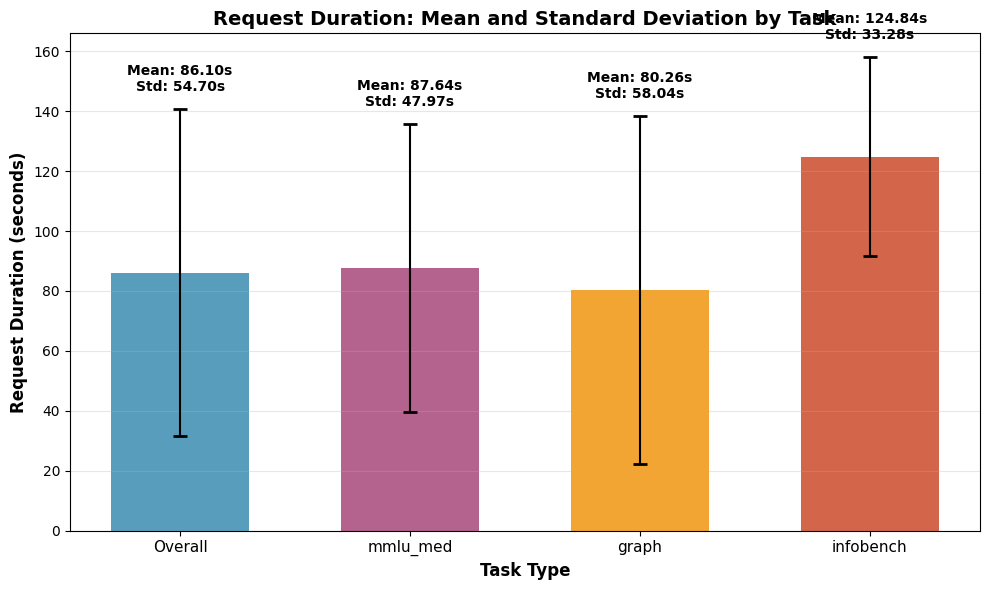

In [60]:
# Figure 1: Request Duration - Bar Chart (Mean and Std)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

tasks = ['Overall', 'mmlu_med', 'graph', 'infobench']
means = [overall_stats['mean']] + [task_stats[t]['mean'] for t in ['mmlu_med', 'graph', 'infobench']]
stds = [overall_stats['std']] + [task_stats[t]['std'] for t in ['mmlu_med', 'graph', 'infobench']]

x = np.arange(len(tasks))
bars = ax.bar(x, means, width=0.6, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'], alpha=0.8)

# Add error bars for std
ax.errorbar(x, means, yerr=stds, fmt='none', ecolor='black', capsize=5, capthick=2)

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 5,
            f'Mean: {mean:.2f}s\nStd: {std:.2f}s',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Task Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Request Duration (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Request Duration: Mean and Standard Deviation by Task', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(tasks, fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

/var/folders/mk/nxkht451133dhgp20m7lk0h80000gn/T/ipykernel_57418/793208234.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6,


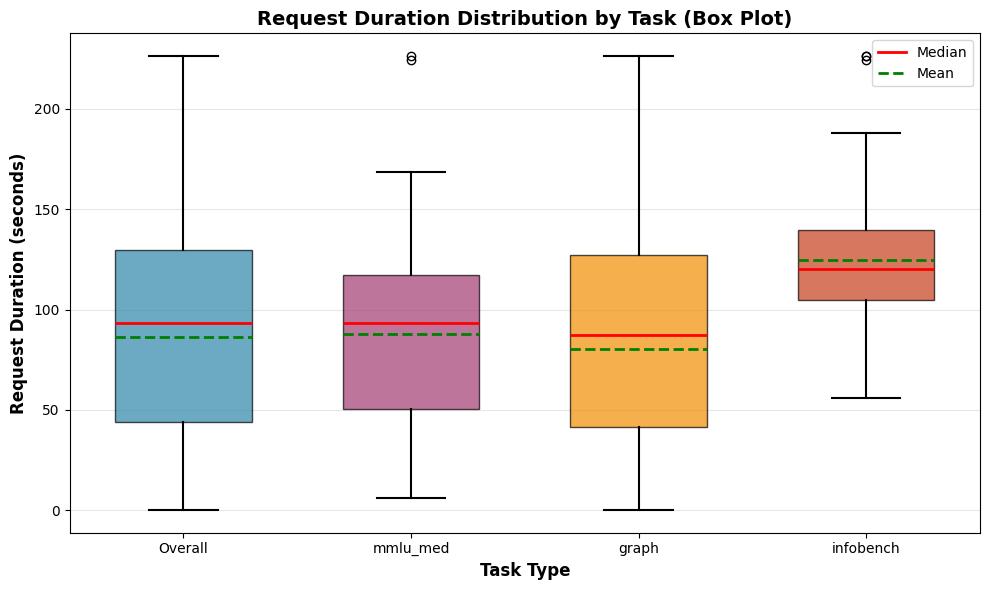

In [61]:
# Figure 2: Request Duration - Distribution by Task (Box Plot)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prepare data for box plot
box_data = [all_durations] + [task_durations[t] for t in ['mmlu_med', 'graph', 'infobench']]
box_labels = ['Overall', 'mmlu_med', 'graph', 'infobench']

bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6,
                showmeans=True, meanline=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                meanprops=dict(color='green', linewidth=2, linestyle='--'),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

# Color each box differently
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xlabel('Task Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Request Duration (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Request Duration Distribution by Task (Box Plot)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', linewidth=2, label='Median'),
                   Line2D([0], [0], color='green', linewidth=2, linestyle='--', label='Mean')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

## Throughput Statistics

**Important Note**: Since each batch contains multiple prompts from different tasks mixed together, we cannot accurately calculate per-task throughput. Each batch has a single request duration that covers all prompts in it, regardless of task type.

What we can calculate:
- Overall system throughput (prompts/second)
- Prompt distribution across tasks
- Average request duration when processing different task types

In [62]:
# Calculate overall throughput and prompt distribution
total_duration = sim_data['actual_duration']

# Count prompts by task
task_prompt_counts = defaultdict(int)
total_prompts = 0

# Also track which batches contain which tasks
batch_task_info = []

for batch in successful_batches:
    batch_tasks = []
    for prompt_idx in batch['prompt_idxs']:
        total_prompts += 1
        task = task_mapping.get(prompt_idx, 'unknown')
        task_prompt_counts[task] += 1
        batch_tasks.append(task)
    
    batch_task_info.append({
        'batch_id': batch['batch_id'],
        'duration': batch['request_duration'],
        'tasks': batch_tasks,
        'task_counts': {t: batch_tasks.count(t) for t in set(batch_tasks)}
    })

# Calculate overall throughput
overall_throughput = total_prompts / total_duration

# Print statistics
print("=" * 80)
print("THROUGHPUT STATISTICS")
print("=" * 80)
print(f"\nOverall System Throughput:")
print(f"  Total Prompts:      {total_prompts}")
print(f"  Total Duration:     {total_duration:.2f}s")
print(f"  Overall Throughput: {overall_throughput:.6f} prompts/s")

print(f"\nPrompt Distribution by Task:")
for task in ['mmlu_med', 'graph', 'infobench']:
    if task in task_prompt_counts:
        count = task_prompt_counts[task]
        percentage = (count / total_prompts) * 100
        # This is NOT true per-task throughput, just the rate at which we see this task
        rate = count / total_duration
        print(f"  {task:12s} - Count: {count:3d} ({percentage:5.1f}%), Rate: {rate:.6f} prompts/s")

print(f"\n  ⚠️  Note: 'Rate' values above are NOT true per-task throughput!")
print(f"     They represent how many prompts of each task were processed per second")
print(f"     over the entire duration, but tasks are batched together, so we cannot")
print(f"     separate their individual processing times.")

# Analyze batches by task composition
print(f"\nBatch Composition Analysis:")
pure_task_batches = defaultdict(list)
mixed_batches = []

for batch_info in batch_task_info:
    unique_tasks = set(batch_info['tasks'])
    if len(unique_tasks) == 1:
        task = list(unique_tasks)[0]
        pure_task_batches[task].append(batch_info['duration'])
    else:
        mixed_batches.append(batch_info)

print(f"  Pure task batches (single task type):")
for task in ['mmlu_med', 'graph', 'infobench']:
    if task in pure_task_batches:
        durations = pure_task_batches[task]
        avg_duration = sum(durations) / len(durations)
        print(f"    {task:12s} - {len(durations):3d} batches, avg duration: {avg_duration:.2f}s")
    else:
        print(f"    {task:12s} - 0 batches")

print(f"  Mixed task batches: {len(mixed_batches)} batches")

print("=" * 80)

THROUGHPUT STATISTICS

Overall System Throughput:
  Total Prompts:      300
  Total Duration:     1268.90s
  Overall Throughput: 0.236426 prompts/s

Prompt Distribution by Task:
  mmlu_med     - Count: 100 ( 33.3%), Rate: 0.078809 prompts/s
  graph        - Count: 100 ( 33.3%), Rate: 0.078809 prompts/s
  infobench    - Count: 100 ( 33.3%), Rate: 0.078809 prompts/s

  ⚠️  Note: 'Rate' values above are NOT true per-task throughput!
     They represent how many prompts of each task were processed per second
     over the entire duration, but tasks are batched together, so we cannot
     separate their individual processing times.

Batch Composition Analysis:
  Pure task batches (single task type):
    mmlu_med     -  12 batches, avg duration: 39.09s
    graph        -  10 batches, avg duration: 5.52s
    infobench    -   6 batches, avg duration: 117.20s
  Mixed task batches: 70 batches


## Throughput Visualizations (2 Figures)

Note: These figures show prompt distribution and processing rates, not true per-task throughput (which cannot be calculated since tasks are batched together).

In [ ]:
# Figure 3: Prompt Processing Rate by Task (Bar Chart)
# Note: This shows the rate at which prompts of each type appear in the processed batches,
# NOT the true per-task throughput (which cannot be separated)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

tasks = ['Overall', 'mmlu_med', 'graph', 'infobench']
# Calculate rates (prompts per second for each task type)
rates = [overall_throughput] + [task_prompt_counts[t] / total_duration for t in ['mmlu_med', 'graph', 'infobench']]

x = np.arange(len(tasks))
bars = ax.bar(x, rates, width=0.6, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'], alpha=0.8)

# Add value labels on bars
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
            f'{rate:.6f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Task Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Processing Rate (prompts/second)', fontsize=12, fontweight='bold')
ax.set_title('Prompt Processing Rate by Task\n(Note: Tasks are batched together; this shows distribution rate, not isolated throughput)', 
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(tasks, fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Figure 4: Prompt Distribution and Batch Composition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Pie chart showing prompt distribution
task_labels = ['mmlu_med', 'graph', 'infobench']
task_counts = [task_prompt_counts[t] for t in task_labels]
colors_pie = ['#A23B72', '#F18F01', '#C73E1D']

wedges, texts, autotexts = ax1.pie(task_counts, labels=task_labels, colors=colors_pie, 
                                    autopct='%1.1f%%', startangle=90, 
                                    textprops={'fontsize': 12, 'fontweight': 'bold'},
                                    explode=(0.05, 0.05, 0.05))

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

ax1.set_title(f'Prompt Distribution by Task\n(Total: {total_prompts} prompts)', 
              fontsize=13, fontweight='bold')

# Right: Bar chart showing pure vs mixed batches
pure_batch_counts = [len(pure_task_batches.get(t, [])) for t in task_labels]
mixed_batch_count = len(mixed_batches)

x = np.arange(len(task_labels))
width = 0.35

bars1 = ax2.bar(x, pure_batch_counts, width, label='Pure Task Batches', 
                color=['#A23B72', '#F18F01', '#C73E1D'], alpha=0.8)

# Add labels on bars
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.axhline(y=mixed_batch_count, color='#2E86AB', linestyle='--', linewidth=2, 
            label=f'Mixed Batches: {mixed_batch_count}')

ax2.set_xlabel('Task Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Batches', fontsize=12, fontweight='bold')
ax2.set_title('Batch Composition: Pure vs Mixed Task Batches', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(task_labels, fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()